Copied from: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Loading

In [2]:
df = pd.read_csv("../data/Concrete_Discrete_16032021.csv")
df.head()

,Image_Action.x,Image_People.x,Image_Emotion.x,Image_Vivid.x,Image_Scenes.x,Response.x,Steps,Effective,Concrete,Emotion,...,Concrete.HighCount,Concrete.HighDensity,Concrete.ExtremeCount,Concrete.ExtremeDensity,Concrete.BigramHighCount,WordCount,Concrete.Level,Concrete.Low,Concrete.Medium,Concrete.High
0,1.0,3.0,3.0,3.0,3.0,I would come up with some possible suggestions...,1.5,2.5,2.5,2.5,...,32,0.201258,12,0.075472,0,159,High,0,0,1
1,2.0,4.0,3.0,4.0,4.0,I would think of a close friend or family memb...,1.0,1.0,1.5,1.5,...,28,0.291667,9,0.093750,1,96,Medium,0,1,0
2,1.0,2.0,1.0,1.0,1.0,Make a plan to reach out to friends and family...,1.5,2.0,1.5,1.5,...,8,0.258065,2,0.064516,1,31,Medium,0,1,0
3,1.0,3.0,3.0,3.0,4.0,I would firstly engage in having a coffee with...,1.5,2.0,2.0,2.0,...,20,0.256410,6,0.076923,0,78,Medium,0,1,0
4,1.0,3.0,3.0,2.0,1.0,This morning I feel lonely as I haven't seen a...,2.0,1.5,2.0,1.5,...,46,0.272189,14,0.082840,0,169,Medium,0,1,0


In [3]:
df = df[df.invalid_response == 0]
df = df[["Response.x", "Concrete.Low"]]
df = df.rename(columns={"Response.x":"Response", "Concrete.Low":"LowConcrete"})
df = df.dropna()

df.head()

,Response,LowConcrete
0,I would come up with some possible suggestions...,0
1,I would think of a close friend or family memb...,0
2,Make a plan to reach out to friends and family...,0
3,I would firstly engage in having a coffee with...,0
4,This morning I feel lonely as I haven't seen a...,0


# Data Preprocessing

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [5]:
MAX_LEN = 400 #Max of BERT is 512

In [6]:
class ConcretenessDataset(Dataset):
  def __init__(self, response, targets, tokenizer, max_len):
    self.response = response
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.response)
  def __getitem__(self, item):
    response = str(self.response[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      response,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )
    return {
      'response': response,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

## Train test split

In [7]:
df_train, df_test = train_test_split(
  df,
  stratify=df.LowConcrete,
  test_size=0.2
)
df_val, df_test = train_test_split(
  df_test,
  stratify=df_test.LowConcrete,
  test_size=0.5
)

In [8]:
df_train.shape, df_val.shape, df_test.shape

((867, 2), (108, 2), (109, 2))

In [9]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ConcretenessDataset(
    response=df.Response.to_numpy(),
    targets=df.LowConcrete.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [10]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Concreteness Predictor

In [11]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
class ConcretenessClassifier(nn.Module):
  def __init__(self):
    super(ConcretenessClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, 1)
    self.out = nn.Sigmoid()
    
  def forward(self, input_ids, attention_mask):
    base_model_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    output = self.drop(base_model_output.pooler_output)
    output = self.linear(output)
    return self.out(output)

In [13]:
model = ConcretenessClassifier()
model = model.to(device)

In [14]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.round(outputs)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      preds = torch.round(outputs)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
torch.tensor(df_train.LowConcrete.to_numpy()[20], dtype=torch.long)

tensor(1)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 20)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
--------------------


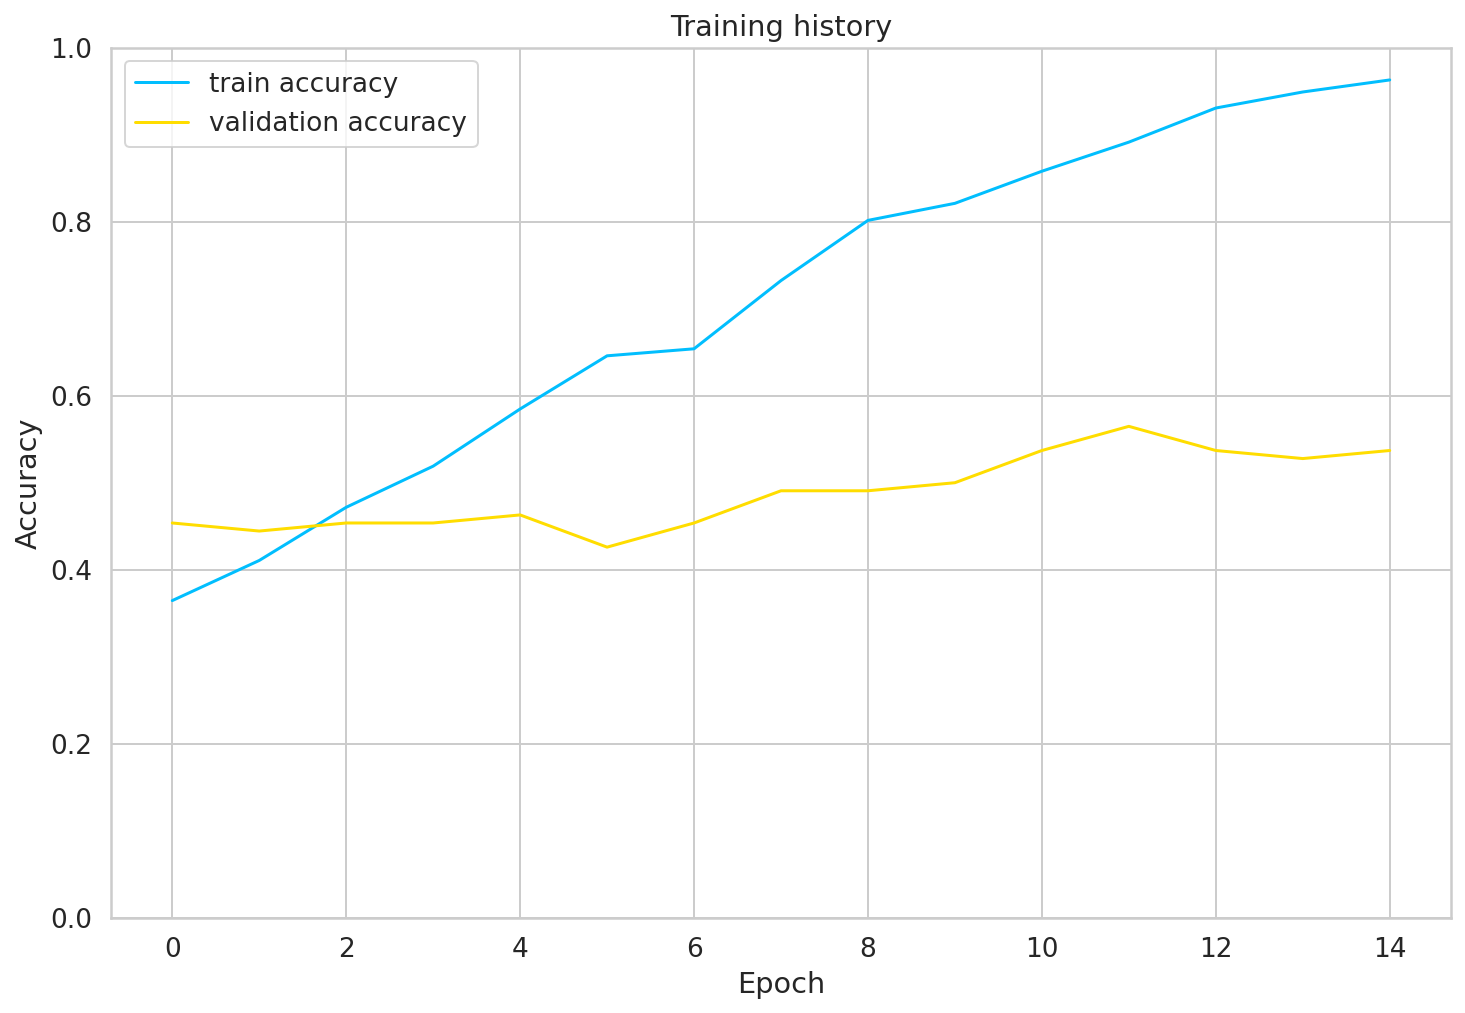

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  response_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["response"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      response_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return response_texts, predictions, prediction_probs, real_values

In [ ]:
y_response_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         Low       0.58      0.31      0.40        36
      Medium       0.43      0.70      0.53        46
        High       0.50      0.30      0.37        27

    accuracy                           0.47       109
   macro avg       0.50      0.43      0.44       109
weighted avg       0.50      0.47      0.45       109



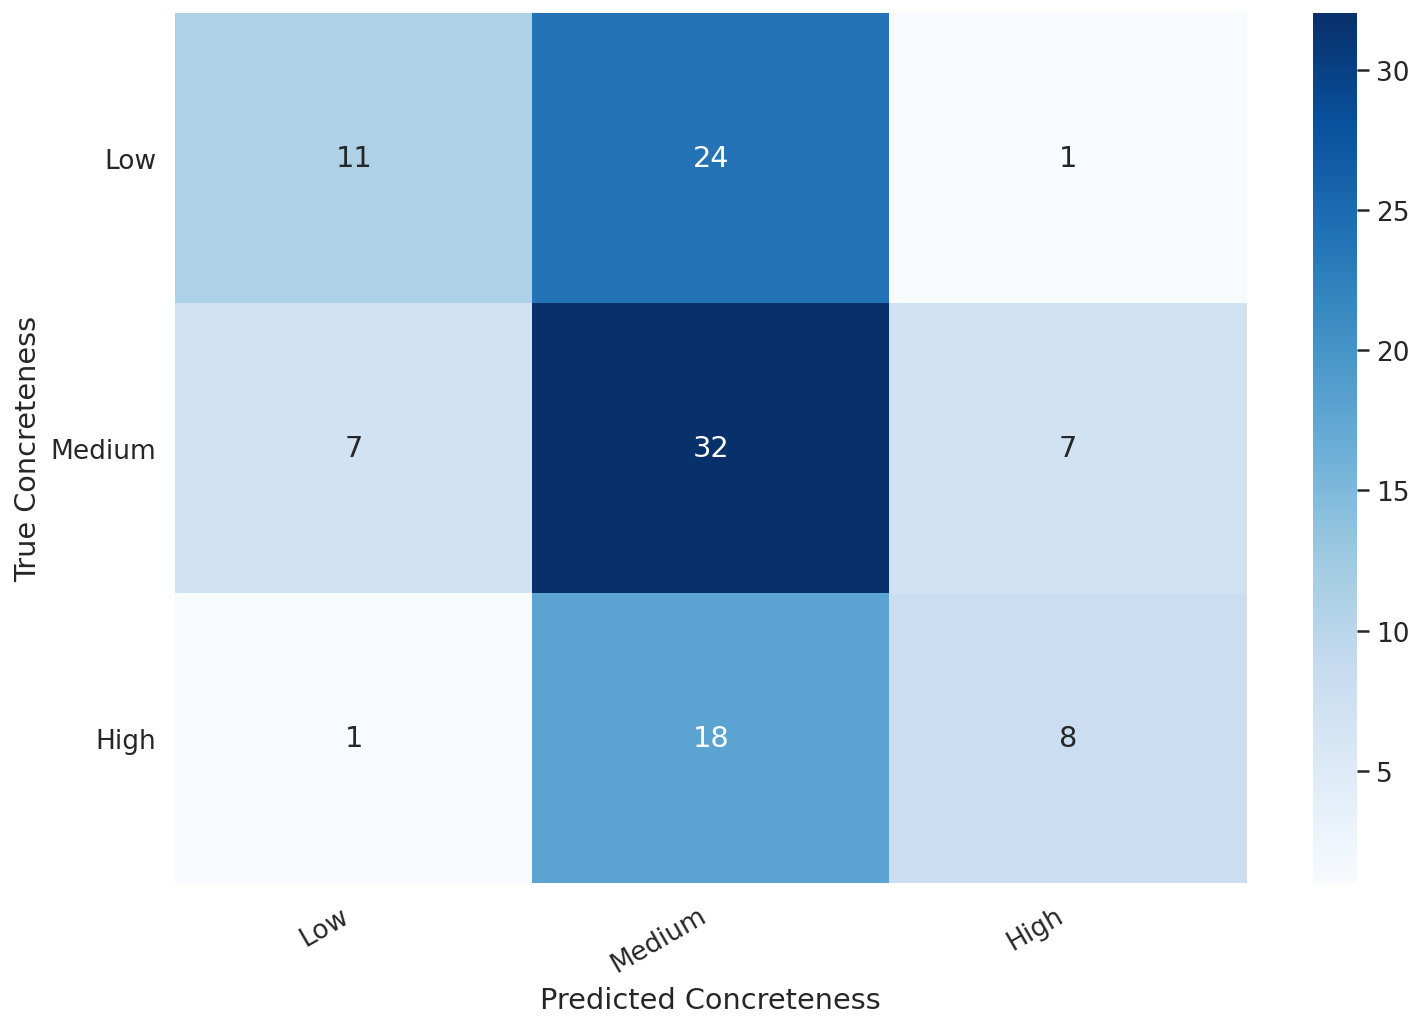

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Concreteness')
  plt.xlabel('Predicted Concreteness');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)